In [1]:
import pandas as pd
import os
import numpy as np
from scipy.stats import mannwhitneyu
import seaborn as sns
from matplotlib import pyplot as plt
import re
import warnings
warnings.filterwarnings('ignore') #supresses warnings for now
#warnings.filterwarnings(action='once') #shows warnings once
from statannotations.Annotator import Annotator


dataFilePath = os.path.join(os.getcwd(),'Data')

kicsSVdf = pd.read_csv(os.path.join(dataFilePath,'kics_structural_variations.txt'), sep = '\t', header = 0)
#kicsTEdf = pd.read_csv(os.path.join(dataFilePath,'kics_transposable_elements.txt'), sep = '\t', header = 0)
lfsSVdf = pd.read_csv(os.path.join(dataFilePath,'lfs_structural_variations.txt'), sep = '\t', header = 0)
#lfsTEdf = pd.read_csv(os.path.join(dataFilePath,'lfs_transposable_elements.txt'), sep = '\t', header = 0)
#kicsClinicdf = pd.read_csv(os.path.join(dataFilePath,'kics_clinical_edited.csv'), encoding='latin-1')
lfsClinicdf = pd.read_csv(os.path.join(dataFilePath,'lfs_clinical_main.tsv'), sep = '\t', header = 0)
kicsClinicdf = pd.read_csv(os.path.join(dataFilePath,'kics_clinical_edited.csv'), encoding='latin-1')



/var/folders/86/098268q515zd4ckwjjr0xbdh0000gp/T/ipykernel_53511/1525248673.py:16: DtypeWarning: Columns (1,35,50,51,52,53,54,60,61,62,63,64,81,86) have mixed types. Specify dtype option on import or set low_memory=False.
  kicsSVdf = pd.read_csv(os.path.join(dataFilePath,'kics_structural_variations.txt'), sep = '\t', header = 0)
/var/folders/86/098268q515zd4ckwjjr0xbdh0000gp/T/ipykernel_53511/1525248673.py:18: DtypeWarning: Columns (1,53,54,58,59,62,63,86) have mixed types. Specify dtype option on import or set low_memory=False.
  lfsSVdf = pd.read_csv(os.path.join(dataFilePath,'lfs_structural_variations.txt'), sep = '\t', header = 0)


In [2]:
"""
full filter
"""

kicsSVdf = kicsSVdf.loc[(kicsSVdf['AnnotSV type'] == 'full')] #& (kicsSVdf['GD_AF'] < 0.01) & (kicsSVdf['GD_AF'] >=0)]
lfsSVdf = lfsSVdf.loc[(lfsSVdf['AnnotSV type'] == 'full')] #& (lfsSVdf['GD_AF'] < 0.01) & (lfsSVdf['GD_AF'] >=0)]

kicsSVdf['SV chrom'] = kicsSVdf['SV chrom'].astype(str)
lfsSVdf['SV chrom'] = lfsSVdf['SV chrom'].astype(str)

#kicsSVnum = kicsSVF['sample_id'].count()
#lfsSVnum = lfsSVF['sample_id'].count()


In [3]:
"""
Kics df cleaning
"""
#listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
listValSearch = ['63', '83', '156', '171', '219', '120', '141', '232']
# searched for kID of 63, 83, 156, 171, 219
# kID 120 141 and 232 do not have any matches...
#what would make this that much better is if it was a dict. Computationally less heavy?
#print(kicsClinicdf.columns)

kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].astype(str)
kicsClinicdf['KiCS ID'] = kicsClinicdf['KiCS ID'].str.replace(" ", "")

for i in listValSearch:
    kicsClinicdf.drop(kicsClinicdf[kicsClinicdf['KiCS ID']==i].index, inplace = True)

kicsClinicdf.drop(kicsClinicdf.loc[kicsClinicdf['tissue_type']=='?'].index, inplace=True)
kicsClinicdf.drop(kicsClinicdf.loc[pd.isna(kicsClinicdf['lfs_cancer_type_diagnosis'])].index, inplace=True)

kUniqueTissue = kicsClinicdf['tissue_type'].unique()
kUniqueDiag = kicsClinicdf['lfs_cancer_type_diagnosis'].unique()

print(kUniqueTissue)
print(kUniqueDiag)

['CNS' 'Colon' 'Bone' 'Blood' 'Thyroid' 'Soft Tissue' 'US' 'Other' 'Liver'
 'Breast' 'Adrenal' 'Ovaries' 'Skin' 'GI']
['Glioma' 'Colon' 'Chordoma' 'OS' 'Meningioma' 'AML/DS' 'Thyroid' 'B-ALL'
 'RMS' 'Undifferentiated sarcoma' 'CML/B-ALL' 'AL' 'PNET' 'Other' 'T-LL'
 'T-NHL' 'MPAL' 'Liver' 'AMKL' 'Breast' 'ACC' 'AML' 'B-NHL' 'Ovaries'
 'Skin' 'GI' 'CPC']


In [4]:
"""
lfs df cleaning
"""
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].str.replace(" ", "")

for i in listValSearch:
    lfsClinicdf.drop(lfsClinicdf[lfsClinicdf['sample']==i].index, inplace = True)

lfsClinicdf.drop(lfsClinicdf.loc[lfsClinicdf['tissue_type']=='?'].index, inplace=True)
lfsClinicdf.drop(lfsClinicdf.loc[pd.isna(lfsClinicdf['cancer_diagnosis'])].index, inplace=True)

lUniqueTissue = lfsClinicdf['tissue_type'].unique()
lUniqueDiag = lfsClinicdf['cancer_diagnosis'].unique()

print(lUniqueTissue)
print(lUniqueDiag)

['Soft Tissue' 'Breast' 'Adrenal' 'CNS' 'Unaffected' 'Blood' 'Bone'
 'Sarcoma' 'Thyroid' 'Cervix' 'Placenta' 'Skin' 'Lung' 'Colon'
 'Angiosarcoma' 'Parathyroid' 'Renal' 'Stromal sarcoma' 'Vulva/Anus'
 'Sebaceous adenocarcinoma']
['RMS' 'Breast' 'ACC' 'Glioma' 'Unaffected' 'ALL' 'AA' 'MFH' 'CPC'
 'High Grade Sarcoma' 'CSA' 'MM' 'PNET' 'LMS' 'OS' 'Sarcoma' 'MFS'
 'Thyroid' 'Cervix' 'NHL' 'Choriocarcinoma' 'Skin' 'Lung' 'Colon'
 'Chordoma' 'GCT' 'Neurilemoma' 'Angiosarcoma' 'Meningioma' 'Parathyroid'
 'Renal' 'FS' 'CTCL' 'Stromal sarcoma' 'DFS' 'Vulva/Anus'
 'Sebaceous adenocarcinoma' 'Spindle cell sarcoma'
 'Undifferentiated sarcoma' 'DLBCL' 'T-LGL']


In [5]:
"""
Difference between the unique tissues and unique diagnosis in kics vs lfs
"""

tissueDiff = list(set(lUniqueTissue).symmetric_difference(set(kUniqueTissue)))
diagDiff = list(set(lUniqueDiag).symmetric_difference(set(kUniqueDiag)))


print(tissueDiff)
print(diagDiff)

# count = 0
# print(len(lUniqueDiag))
# for i in lUniqueDiag:
#     if i in diagDiff:
#         count = count+1
        
# print(count)

['Placenta', 'Sarcoma', 'Vulva/Anus', 'Parathyroid', 'Cervix', 'Renal', 'Stromal sarcoma', 'GI', 'Sebaceous adenocarcinoma', 'Ovaries', 'Other', 'Unaffected', 'US', 'Liver', 'Lung', 'Angiosarcoma']
['GCT', 'MPAL', 'Choriocarcinoma', 'AML/DS', 'AMKL', 'B-NHL', 'AML', 'AA', 'Lung', 'MFS', 'T-NHL', 'AL', 'Parathyroid', 'CSA', 'ALL', 'Renal', 'Stromal sarcoma', 'Neurilemoma', 'Ovaries', 'Liver', 'DLBCL', 'Angiosarcoma', 'T-LL', 'MFH', 'LMS', 'Sarcoma', 'High Grade Sarcoma', 'Cervix', 'CML/B-ALL', 'MM', 'Other', 'Vulva/Anus', 'T-LGL', 'NHL', 'B-ALL', 'FS', 'Spindle cell sarcoma', 'GI', 'CTCL', 'Unaffected', 'DFS', 'Sebaceous adenocarcinoma']


In [28]:
"""
Drop the rows that are in the diff
"""

lfsTissue = lfsClinicdf[~lfsClinicdf['tissue_type'].isin(tissueDiff)]
kicsTissue = kicsClinicdf[~kicsClinicdf['tissue_type'].isin(tissueDiff)]

lfsDiag = lfsClinicdf[~lfsClinicdf['cancer_diagnosis'].isin(diagDiff)]
kicsDiag = kicsClinicdf[~kicsClinicdf['lfs_cancer_type_diagnosis'].isin(diagDiff)]

#print(kicsTissue.columns)

kicsTissue = pd.DataFrame(data = {'tissue_type':kicsTissue['tissue_type'], 'id':kicsTissue['KiCS ID'], 
                                  'ccp':kicsTissue['CCP germline']})
kicsT = kicsTissue

lfsTissue = pd.DataFrame(data = {'tissue_type':lfsTissue['tissue_type'], 'id':lfsTissue['sample']})
lfsT = lfsTissue

groupedTissue = pd.DataFrame(data={'ktissue':kicsTissue['tissue_type'], 'ltissue':lfsTissue['tissue_type']})

lfsDiag = pd.DataFrame(data = {'diag':lfsDiag['cancer_diagnosis'], 'id':lfsDiag['sample']})
lfsD = lfsDiag
kicsDiag = pd.DataFrame(data = {'diag':kicsDiag['lfs_cancer_type_diagnosis'], 'id':kicsDiag['KiCS ID'],
                                'ccp':kicsDiag['CCP germline']})
kicsD = kicsDiag

groupedDiag = pd.DataFrame(data={'kdiag':kicsDiag['diag'],'ldiag': lfsDiag['diag']})

kicsTidList = kicsDiag['id'].unique()
lfsTidList = lfsDiag['id'].unique()
kicsDiagList = kicsDiag['diag'].unique()

kicsIdList = kicsTissue['id'].unique()
kicsTissueList = kicsTissue['tissue_type'].unique()
#lfsTissueList = lfsTissue['tissue_type'].unique()
lfsIdList = lfsTissue['id'].unique()

print(kicsTissue['tissue_type'].unique())
print(lfsTissue['tissue_type'].unique())
#print(lfsTissue.columns)
#print(lfsTissueList)




['CNS' 'Colon' 'Bone' 'Blood' 'Thyroid' 'Soft Tissue' 'Breast' 'Adrenal'
 'Skin']
['Soft Tissue' 'Breast' 'Adrenal' 'CNS' 'Blood' 'Bone' 'Thyroid' 'Skin'
 'Colon']


In [7]:
def BoxGraphMulti(df: pd.DataFrame, xCol, yCol, compCol, orderList):
    plt.rcParams["figure.figsize"] = [15, 15]
    ax = sns.boxplot(data=df, x=xCol, y=yCol, hue=compCol, medianprops={"linewidth": 4, 'color':'black'})
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
    
    #add statistical test here
    listPairing = []
    #pairings for multi correction
    for i in orderList:
        p1 = (i, 'kics')
        p2 = (i, 'lfs')
        p = (p1,p2)
        listPairing.append(p)
        
    annot = Annotator(ax, listPairing, data=df, x=xCol, y=yCol, hue=compCol)
    annot.configure(test='Mann-Whitney', text_format='star', loc='outside', verbose=2)
    annot.apply_and_annotate()

    plt.show()

    plt.show()

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Thyroid_kics vs. Thyroid_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:1.774e-01 U_stat=2.288e+04
Blood_kics vs. Blood_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:5.980e-12 U_stat=2.720e+04
Adrenal_kics vs. Adrenal_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:8.841e-08 U_stat=1.838e+04


/Users/katherineqin/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/Users/katherineqin/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


Bone_kics vs. Bone_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:6.968e-01 U_stat=2.277e+04
CNS_kics vs. CNS_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:7.313e-08 U_stat=2.764e+04
Colon_kics vs. Colon_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:9.923e-01 U_stat=2.250e+04
Soft Tissue_kics vs. Soft Tissue_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:8.137e-01 U_stat=2.270e+04
Breast_kics vs. Breast_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:3.701e-10 U_stat=1.695e+04
Skin_kics vs. Skin_lfs: Mann-Whitney-Wilcoxon test two-sided, P_val:8.480e-02 U_stat=2.190e+04


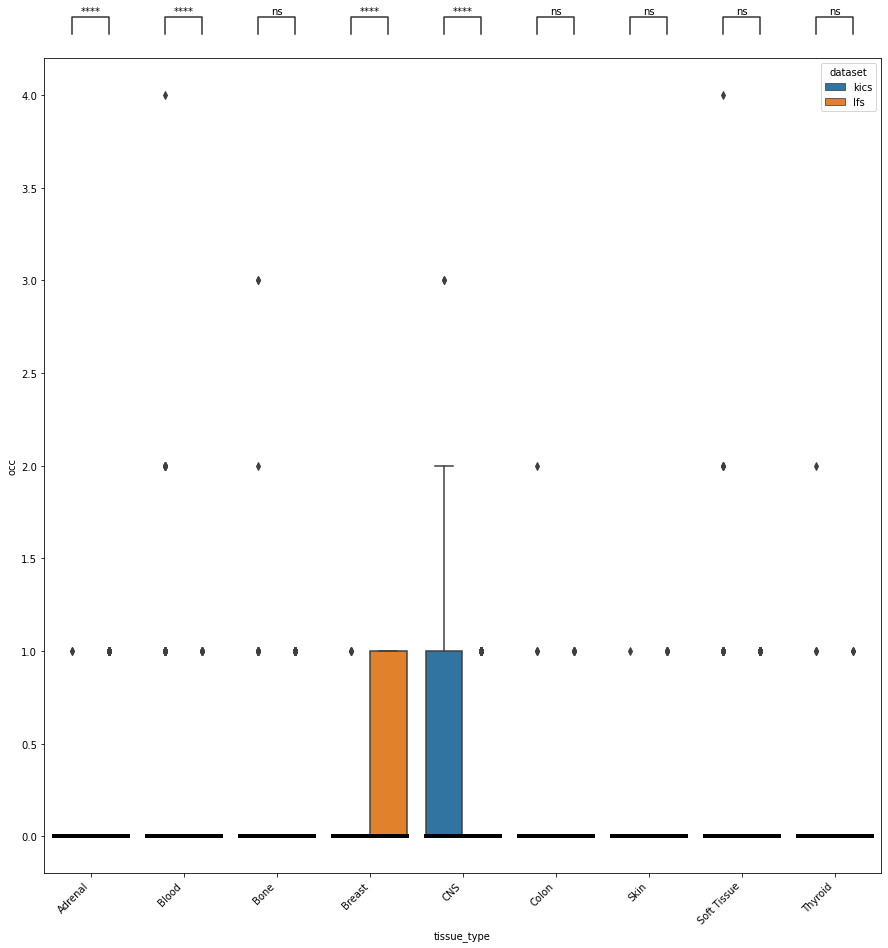

In [8]:
"""
get it into the form wanted
"""

kicsTissue = kicsTissue.groupby(['id','tissue_type']).size().unstack(fill_value=0)
kicsTissue = kicsTissue.stack().unstack(1)
kicsTissue = kicsTissue.reset_index()
#print(kicsTissue)
#print(kicsTissue.columns)

df = kicsTissue.drop(['id'], axis=1)
df = df.stack(0)
df = df.reset_index().drop(['level_0'],axis=1)
df['dataset'] = 'kics'
#print(df.head(50))

lfsTissue = lfsTissue.groupby(['id','tissue_type']).size().unstack(fill_value=0)
lfsTissue = lfsTissue.stack().unstack(1).reset_index()
dfL = lfsTissue.drop(['id'], axis=1).stack(0).reset_index().drop(['level_0'],axis=1)
dfL['dataset']='lfs'
#print(dfL.head(50))

mergedTissue = pd.concat([df, dfL])
mergedTissue.rename(columns = {0:'occ'}, inplace=True)

#print(mergedTissue.head(30))



BoxGraphMulti(mergedTissue, 'tissue_type', 'occ', 'dataset', kicsTissueList)

In [10]:
kicsDiag = kicsDiag.groupby(['id','diag']).size().unstack(fill_value=0)
kicsDiag = kicsDiag.stack().unstack(1)
kicsDiag = kicsDiag.reset_index()
#print(kicsTissue)
#print(kicsTissue.columns)

df = kicsDiag.drop(['id'], axis=1)
df = df.stack(0)
df = df.reset_index().drop(['level_0'],axis=1)
df['dataset'] = 'kics'
#print(df.head(50))

lfsDiag = lfsDiag.groupby(['id','diag']).size().unstack(fill_value=0)
lfsDiag = lfsDiag.stack().unstack(1).reset_index()
dfL = lfsDiag.drop(['id'], axis=1).stack(0).reset_index().drop(['level_0'],axis=1)
dfL['dataset']='lfs'
#print(dfL.head(50))

mergedDiag = pd.concat([df, dfL])
mergedDiag.rename(columns = {0:'occ'}, inplace=True)

#print(mergedDiag.head(30))

BoxGraphMulti(mergedDiag, 'diag', 'occ', 'dataset', kicsDiagList)

KeyError: 'diag'

In [11]:
def BarGraphNormalized(label1: str, label2:str, df: pd.DataFrame, col1: str, col2: str,
                        xTitle: str, yTitle: str, divisor1: float, divisor2: float,
                        labels: list):
    #'kics', 'lfs', invdf, 'kchrom', 'lchrom', 'Chromosomes','Frequency','Graph2-INV',kicsSVnum, lfsSVnum

    title = label1 + " " + label2
    count1 = df[col1].value_counts()
    count2 = df[col2].value_counts()
    
    x_axis = np.arange(len(labels))
        
    for i in labels:
        if (not(i in count1)):
            add = pd.Series([0], index=[i])
            count1 = count1.append(add)
        if (not(i in count2)):
            add = pd.Series([0], index=[i])
            count2 = count2.append(add)
            
    
    plt.bar(x_axis - 0.2, [count1[a]/divisor1 for a in labels], 0.4, label = label1)
    plt.bar(x_axis + 0.2, [count2[a]/divisor2 for a in labels], 0.4, label = label2)

    plt.tick_params(labelrotation=45)
    plt.xticks(x_axis, labels)
    plt.xlabel(xTitle)
    plt.ylabel(yTitle)
    plt.title(title)
    plt.legend()
    plt.show()


# Tissue Type

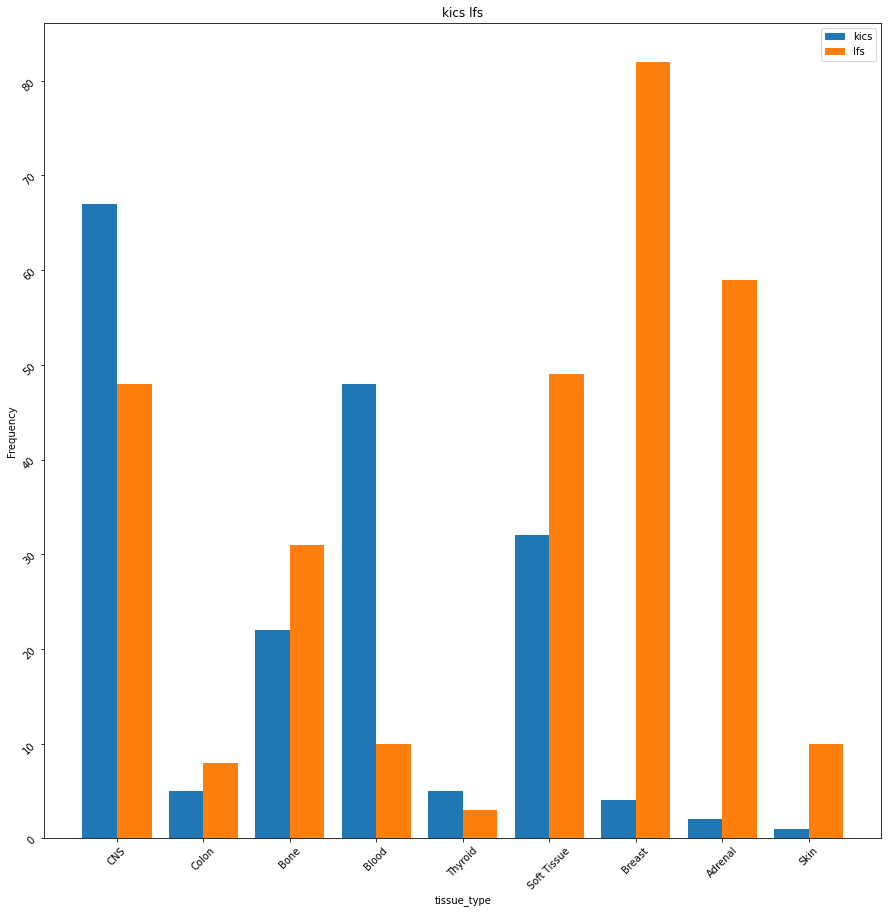

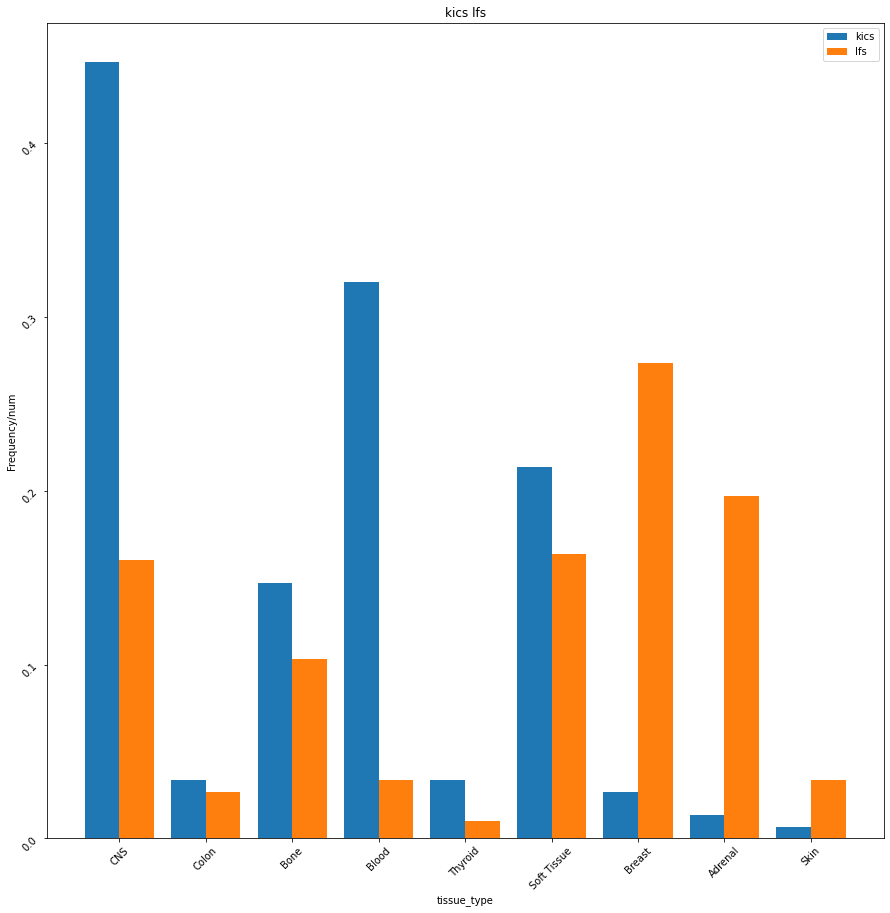

In [12]:
BarGraphNormalized('kics', 'lfs', groupedTissue, 'ktissue', 'ltissue', 'tissue_type','Frequency',
                   1.0,1.0, kicsTissueList)

BarGraphNormalized('kics', 'lfs', groupedTissue, 'ktissue', 'ltissue', 'tissue_type', 'Frequency/num',
                  len(kicsIdList), len(lfsIdList), kicsTissueList)

# Diagnosis Type

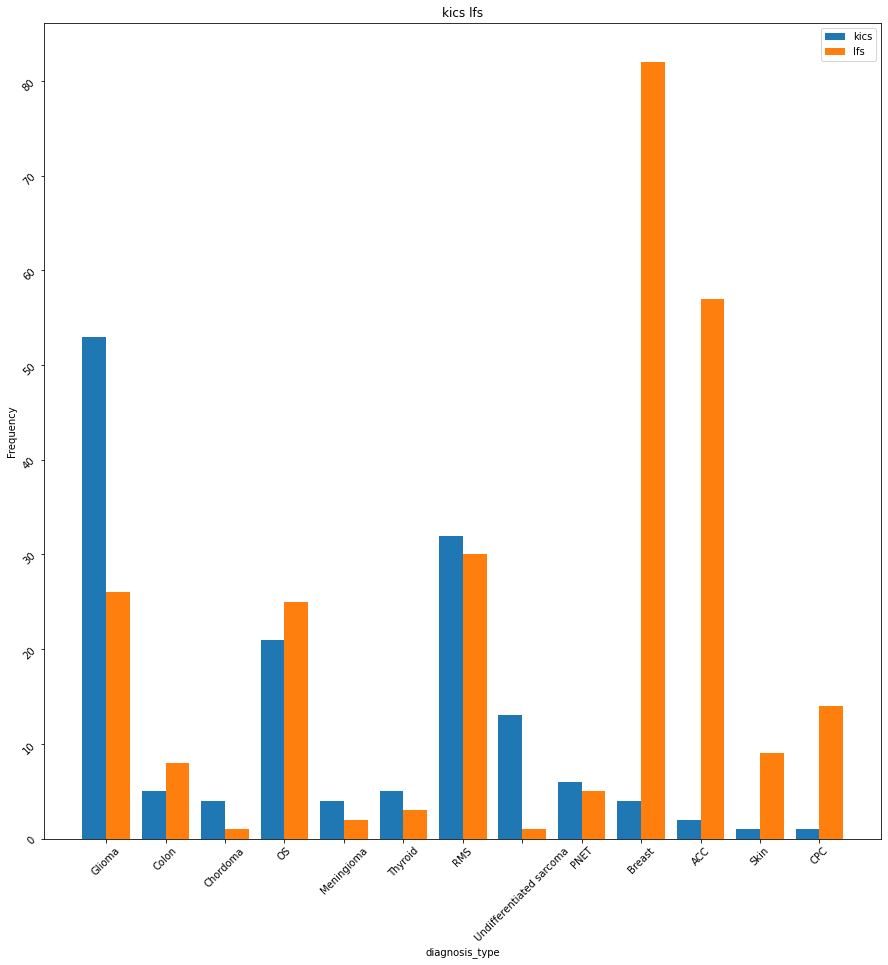

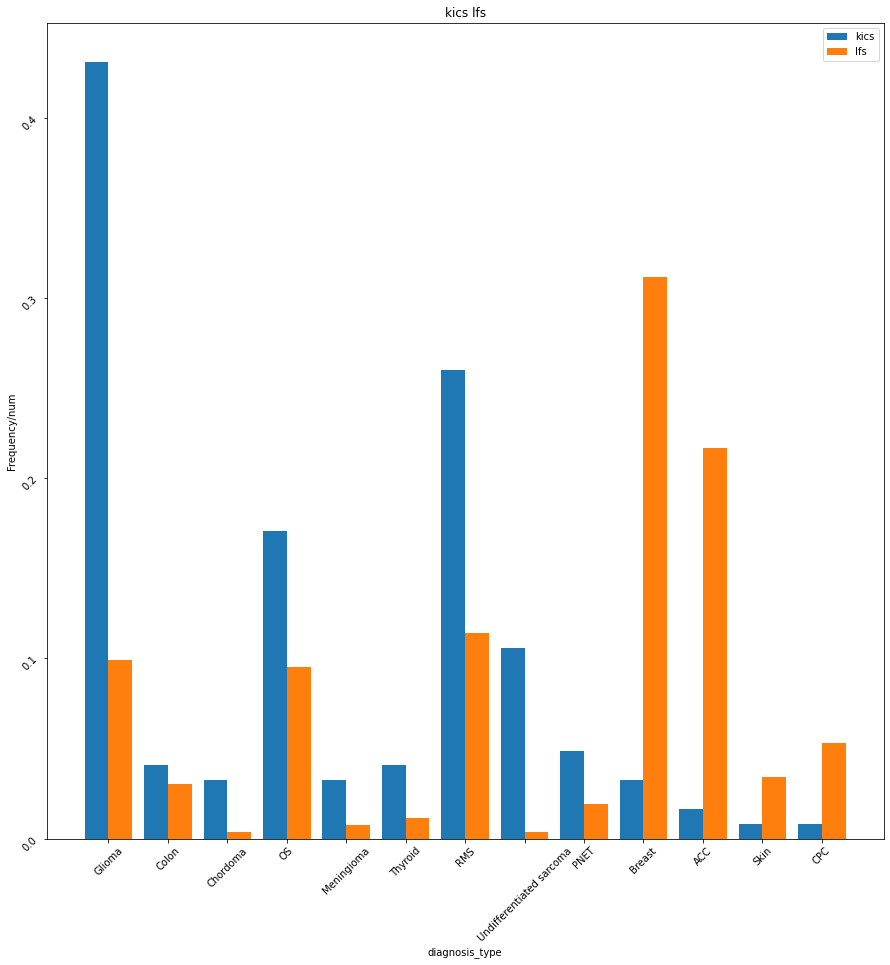

In [13]:
BarGraphNormalized('kics', 'lfs', groupedDiag, 'kdiag', 'ldiag', 'diagnosis_type', 'Frequency', 1.0,1.0, kicsDiagList)
    
BarGraphNormalized('kics', 'lfs', groupedDiag, 'kdiag', 'ldiag', 'diagnosis_type','Frequency/num',
                   len(kicsTidList), len(lfsTidList), kicsDiagList)

In [14]:
"""
SV clean up
"""
def maxGDAFFilter(colName: str, df: pd.DataFrame)->pd.DataFrame:
    temp = df[colName].str.contains(pat=',')
    Index = list(np.where(temp == True)[0])
    temp = df[colName].iloc[Index]
    tempIndex = temp.index

    for i in tempIndex:
        tempList = temp[i].split(',')
        tempList = [float(a) for a in tempList]
        maxTemp = max(tempList)
        df[colName][i] = maxTemp

    df[colName] = df[colName].astype('float64')
    
    return df
    
kicsSVdf = maxGDAFFilter('GD_AF', kicsSVdf)
lfsSVdf = maxGDAFFilter('GD_AF', lfsSVdf)

listValSearch = ['291775', '298313', '315666', '320118', '18_1907']
# searched for kID of 63, 83, 156, 171, 219
# kID 120 141 and 232 do not have any matches...
#what would make this that much better is if it was a dict. Computationally less heavy?

for i in listValSearch: 
    kicsSVdf.drop(kicsSVdf[kicsSVdf['sample_id'].str.contains(i)==True].index, inplace = True)

/var/folders/86/098268q515zd4ckwjjr0xbdh0000gp/T/ipykernel_53511/537495065.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[colName][i] = maxTemp


In [15]:
def kIdAbbv(clinicDf, svDf, clinicCol, svCol, svColList, clinicColList):
    
    clinicDf.drop(clinicDf[clinicDf[clinicCol]=='Not applicable'].index, inplace = True)
    
    svDf[svCol] = svDf[svCol].astype(str)
    clinicDf[clinicCol] = clinicDf[clinicCol].astype(str)
    svDf[svCol] =  svDf[svCol].str.replace(" ", "")
    clinicDf[clinicCol] = clinicDf[clinicCol].str.replace(" ", "")
    
    list1 = svDf[svCol].unique()
    list2 = clinicDf[clinicCol].unique()
    
    svDict = dict()
    clinicDict = dict()
    
    for i in range (len(list1)):
        tempList = re.findall('\d{3,}', list1[i])

        #if empty, take the second one
        if not tempList:
            tempList = re.findall('\d+', list1[i])
            svDict[list1[i]] = tempList[1]

        #if not empty 
        else:
            svDict[list1[i]] = tempList[0]


    for i in range (len(list2)):    
        tempList = re.findall('\d{3,}', list2[i])
    
        #if empty, take the second one
        if not tempList:
            tempList = re.findall('\d+', list2[i])
            clinicDict[list2[i]] = tempList[1]

        #if not empty 
        else:
            clinicDict[list2[i]] = tempList[0]
    

    clinicDf['abbv_id'] = clinicDf[clinicCol].map(clinicDict)
    svDf['abbv_id'] = svDf[svCol].map(svDict)
    
    print(len(svDf[svCol].unique()))
    
    svColList.extend(('abbv_id',svCol))
    clinicColList.extend(('abbv_id',clinicCol))
    
    df = pd.merge(svDf[svColList], clinicDf[clinicColList],
#                      svDf[[svCol,'SV type','abbv_id']],                   
                     #clinicDf[[clinicCol, 'tumour_class','tissue_type','lfs_cancer_type_diagnosis', 'abbv_id']],
                     
                     left_on = 'abbv_id', 
                     right_on = 'abbv_id', 
                     how='inner')

    return df

<>:17: DeprecationWarning: invalid escape sequence \d


In [16]:
print(kicsTissue.columns)

bigKDfTissue = kIdAbbv(kicsT, kicsSVdf, 'ccp', 'sample_id',['SV type'], ['tissue_type'])
print(bigKDfTissue.head(30))
print(len(bigKDfTissue['abbv_id'].unique()))
#prints out how many we had before the id matching and how many we have left after the id matching

Index(['id', 'Adrenal', 'Blood', 'Bone', 'Breast', 'CNS', 'Colon', 'Skin',
       'Soft Tissue', 'Thyroid'],
      dtype='object', name='tissue_type')
191
   SV type abbv_id sample_id tissue_type     ccp
0      DEL  313703    313703         CNS  313703
1      DEL  313703    313703         CNS  313703
2      DEL  313703    313703         CNS  313703
3      DEL  313703    313703         CNS  313703
4      DEL  313703    313703         CNS  313703
5      DEL  313703    313703         CNS  313703
6      DEL  313703    313703         CNS  313703
7      DEL  313703    313703         CNS  313703
8      DEL  313703    313703         CNS  313703
9      DEL  313703    313703         CNS  313703
10     DEL  313703    313703         CNS  313703
11     DUP  313703    313703         CNS  313703
12     DEL  313703    313703         CNS  313703
13     DEL  313703    313703         CNS  313703
14     DEL  313703    313703         CNS  313703
15     DEL  313703    313703         CNS  313703
16     DEL  

In [17]:
print(bigKDfTissue)

      SV type abbv_id sample_id tissue_type     ccp
0         DEL  313703    313703         CNS  313703
1         DEL  313703    313703         CNS  313703
2         DEL  313703    313703         CNS  313703
3         DEL  313703    313703         CNS  313703
4         DEL  313703    313703         CNS  313703
...       ...     ...       ...         ...     ...
21112     INV  292600    292600       Blood  292600
21113     DEL  292600    292600       Blood  292600
21114     DEL  292600    292600       Blood  292600
21115     DEL  292600    292600       Blood  292600
21116     DEL  292600    292600       Blood  292600

[21117 rows x 5 columns]


In [18]:
"""Filter the ? and the nan"""

#print(bigKDf['tissue_type'].unique())
bigKDfTissue.drop(bigKDfTissue.loc[bigKDfTissue['tissue_type']=='?'].index, inplace=True)

#bigKDfDiag.drop(bigKDf.loc[pd.isna(bigKDf['lfs_cancer_type_diagnosis'])].index, inplace=True)
print(len(bigKDfTissue['abbv_id'].unique()))
#print(kicsClinicdf['tissue_type'].value_counts())

72


In [19]:
lfsSVdf['sample_id'] = lfsSVdf['sample_id'].astype(str)
lfsClinicdf['sample'] = lfsClinicdf['sample'].astype(str)

In [20]:
print(len(lfsSVdf['sample_id'].unique())) #only 65 to begin with D:
print(lfsSVdf['sample_id'].unique())

print(len(lfsClinicdf['sample'].unique()))

65
['4257' 'SJACT008_G' '808' '2085' '1087' '1092' '3805' '3136A' '4033'
 '2447' '353' '3806' '4854' '1478' '2262' '4028' '2957' '3688' '93' '1357'
 '2565' '4329' '4535_S1' '3298A' '2349' '2446' '3473' '5567' '3273' '3885'
 '3432' '1843' '3763' '3503' 'PD13489b' '2463' '2760A' '3643' 'SJACT001_G'
 '4227' '5537' '3367' 'SJACT002_G' '2815' '5536' '3634' '1476'
 'SJACT005_G' '3425' '3365' '2413' 'SJACT007_G' '3356' '3361' '3687_2'
 '3332' '94' '1355' '2784' '2465' '3319' 'PD7195b' '3334' '352' '2765']
460


In [21]:
#print(lfsClinicdf.columns)

#print(lfsSVdf.columns)

"""
drop unaffected? and NA? 
- Keeping unaffected and NA
Which column do i use for id
- sample
"""
#print(set(lfsSVdf['sample_id']).difference(set(lfsClinicdf['sample'])))

'\ndrop unaffected? and NA? \n- Keeping unaffected and NA\nWhich column do i use for id\n- sample\n'

In [22]:
"""
Can directly map the two
Apply on Filtered Prelim Graphs
"""

#print(lfsSVdf.columns)
# bigLDf = pd.merge(lfsSVdf[['sample_id','SV chrom','GD_AF', 'SV type']], 
#                      lfsClinicdf[['sample','tissue_type', 'cancer_diagnosis', 'active_cancer', 'gender']],
#                      left_on = 'sample_id', 
#                      right_on = 'sample', d
#                      how='inner')

#print(lfsTissue.columns)

bigLDfTissue = pd.merge(lfsSVdf[['sample_id','SV chrom','GD_AF', 'SV type']],
                 lfsT[['id','tissue_type']],
                 left_on = 'sample_id',
                 right_on = 'id',
                 how='inner')

#print(bigLDf)
#print(len(bigLDf['sample_id'].unique()))


In [23]:
#bigLDf and bigKDf

#print(bigLDf.columns)
#print(bigKDf.head(30))

kDel = bigKDfTissue.loc[bigKDfTissue['SV type'] == 'DEL']
kDup = bigKDfTissue.loc[bigKDfTissue['SV type'] == 'DUP']
kInv = bigKDfTissue.loc[bigKDfTissue['SV type'] == 'INV']

lDel = bigLDfTissue.loc[bigLDfTissue['SV type'] == 'DEL']
lDup = bigLDfTissue.loc[bigLDfTissue['SV type'] == 'DUP']
lInv = bigLDfTissue.loc[bigLDfTissue['SV type'] == 'INV']

print(kDel.head(30))

#print(kDel.value)

   SV type abbv_id sample_id tissue_type     ccp
0      DEL  313703    313703         CNS  313703
1      DEL  313703    313703         CNS  313703
2      DEL  313703    313703         CNS  313703
3      DEL  313703    313703         CNS  313703
4      DEL  313703    313703         CNS  313703
5      DEL  313703    313703         CNS  313703
6      DEL  313703    313703         CNS  313703
7      DEL  313703    313703         CNS  313703
8      DEL  313703    313703         CNS  313703
9      DEL  313703    313703         CNS  313703
10     DEL  313703    313703         CNS  313703
12     DEL  313703    313703         CNS  313703
13     DEL  313703    313703         CNS  313703
14     DEL  313703    313703         CNS  313703
15     DEL  313703    313703         CNS  313703
16     DEL  313703    313703         CNS  313703
17     DEL  313703    313703         CNS  313703
18     DEL  313703    313703         CNS  313703
19     DEL  313703    313703         CNS  313703
20     DEL  313703  

In [24]:
# kdeldf = kDel.drop(['sample_id', 'ccp', 'SV type'], axis=1)

# #print(kdeldf.head(30))
# kdeldf = kdeldf.groupby(['abbv_id']).value_counts()#.to_frame()#.size()#.unstack()
# kdeldf = kdeldf.to_frame().reset_index()

# kdeldf.rename(columns = {0:'freq'}, inplace = True)

# #print(kdeldf)

# kdeldf = pd.melt(kdeldf, id_vars=['tissue_type'], value_vars=['freq'])

# #print(kdeldf.head(30))
# # kdeldf = kdeldf.stack()#.unstack(1)
# # kdeldf = kdeldf.reset_index()
# # kdeldf = kdeldf.drop(['abbv_id'],axis=1)
# kdeldf['dataset'] = 'kics'

# #print(lDel.columns)

# ldeldf = lDel.drop(['SV chrom', 'GD_AF',
#                     'SV type', 'sample_id'], axis=1)

# ldeldf = ldeldf.groupby(['id']).value_counts()#size().unstack(fill_value=0)
# ldeldf = ldeldf.to_frame().reset_index()
# ldeldf.rename(columns = {0:'freq'}, inplace = True)

# ldeldf = pd.melt(ldeldf, id_vars=['tissue_type'], value_vars=['freq'])
# ldeldf['dataset'] = 'lfs'

# # ldeldf = ldeldf.reset_index()
# # ldeldf = ldeldf.drop(['sample'],axis=1)
# # ldeldf['dataset'] = 'lfs'
# # #print(ldeldf.head(30))

# delMergedDf = pd.concat([ldeldf, kdeldf])
# #print(delMergedDf)

# BoxGraphMulti(delMergedDf,'tissue_type', 'value', 'dataset')


In [25]:
def graphSVTissue(kdf, ldf, listTissue):
    kdf = kdf.drop(['sample_id', 'ccp', 'SV type'], axis=1)
    kdf = kdf.groupby(['abbv_id']).value_counts()
    kdf = kdf.to_frame().reset_index()

    kdf.rename(columns = {0:'freq'}, inplace = True)
    kdf = pd.melt(kdf, id_vars=['tissue_type'], value_vars=['freq'])
    kdf['dataset'] = 'kics'

    ldf = ldf.drop(['SV chrom', 'GD_AF',
                        'SV type', 'sample_id'], axis=1)
    ldf = ldf.groupby(['id']).value_counts()
    ldf = ldf.to_frame().reset_index()
    ldf.rename(columns = {0:'freq'}, inplace = True)

    ldf = pd.melt(ldf, id_vars=['tissue_type'], value_vars=['freq'])
    ldf['dataset'] = 'lfs'

    mergedDf = pd.concat([ldf, kdf])
    
    BoxGraphMulti(mergedDf,'tissue_type', 'value', 'dataset', listTissue) 

## DEL

['CNS' 'Soft Tissue' 'Blood' 'Bone' 'Thyroid' 'Breast' 'Colon' 'Adrenal']
['Breast' 'Adrenal' 'Soft Tissue' 'Blood' 'Bone' 'CNS' 'Colon']


/Users/katherineqin/opt/anaconda3/lib/python3.9/site-packages/seaborn/categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
/Users/katherineqin/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


ValueError: Missing group value `Skin` in tissue_type (specified in `pairs`)

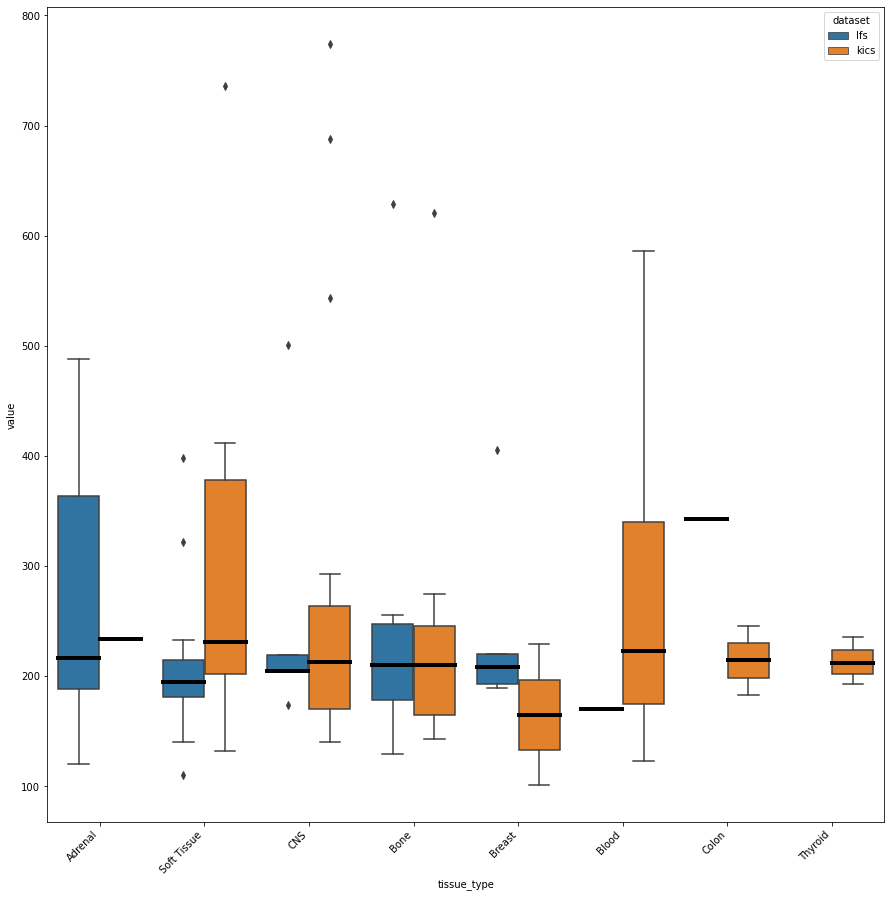

In [32]:
print(kDel['tissue_type'].unique())
print(lDel['tissue_type'].unique())
graphSVTissue(kDel, lDel, kicsTissueList)


## DUP

In [27]:
print(kicsTissueList)
graphSVTissue(kDup, lDup)


['CNS' 'Colon' 'Bone' 'Blood' 'Thyroid' 'Soft Tissue' 'Breast' 'Adrenal'
 'Skin']


TypeError: graphSVTissue() missing 1 required positional argument: 'listTissue'

## INV

In [ ]:
graphSVTissue(kInv, lInv, kicsTissueList)

In [ ]:
"""
rare variants first
LFS vs Kics for Diagnosis type
LFS vs unaffected
"""

